Notebook for predicting PRNG sequence of subtractive generator using deep learning  
Blog: https://medium.com/@prashantlimba/predicting-prng-sequence-of-subtractive-generator-using-deep-learning-4aa19f159dc4  

## 📥 Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow import keras
from sklearn.model_selection import train_test_split

pd.set_option('display.float_format', '{:.7f}'.format)

2024-04-04 04:41:04.051383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 04:41:04.051443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 04:41:04.052937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 🔧 Utility functions

In [2]:
class Random:
    '''
    C# Random class translated into python
    Reference: https://github.com/microsoft/referencesource/blob/master/mscorlib/system/random.cs
    '''
    MBIG = 2147483647
    MSEED = 161803398
    MZ = 0

    def __init__(self, seed=None):
        self.inext = 0
        self.inextp = 21
        self.SeedArray = [0] * 56

        seed = seed or int(time.time())
        subtraction = MBIG if seed == -2147483648 else abs(seed)
        mj = self.MSEED - subtraction
        self.SeedArray[55] = mj
        mk = 1

        for i in range(1, 55):
            ii = (21 * i) % 55
            self.SeedArray[ii] = mk
            mk = mj - mk
            if mk < 0:
                mk += self.MBIG
            mj = self.SeedArray[ii]

        for k in range(1, 5):
            for i in range(1, 56):
                self.SeedArray[i] -= self.SeedArray[1 + (i + 30) % 55]
                if self.SeedArray[i] < 0:
                    self.SeedArray[i] += self.MBIG

        self.inext = 0
        self.inextp = 21

    def sample(self):
        return self.internal_sample() * (1.0 / self.MBIG)

    def internal_sample(self):
        loc_inext = self.inext + 1
        loc_inextp = self.inextp + 1

        if loc_inext >= 56:
            loc_inext = 1
        if loc_inextp >= 56:
            loc_inextp = 1

        ret_val = self.SeedArray[loc_inext] - self.SeedArray[loc_inextp]

        if ret_val == self.MBIG:
            ret_val -= 1
        if ret_val < 0:
            ret_val += self.MBIG

        self.SeedArray[loc_inext] = ret_val

        self.inext = loc_inext
        self.inextp = loc_inextp

        return ret_val

    def next(self):
        return self.internal_sample()

    def get_sample_for_large_range(self):
        result = self.internal_sample()
        negative = True if self.internal_sample() % 2 == 0 else False
        if negative:
            result = -result
        d = float(result)
        d += (self.MBIG - 1)
        d /= 2 * self.MBIG - 1
        return d

    def next_range(self, min_value, max_value):
        '''Generate integer number between min_value and max_value'''
        if min_value > max_value:
            raise ValueError("min_value must be less than or equal to max_value")

        range_val = max_value - min_value

        if range_val <= self.MBIG:
            tmp = self.sample()
            return (int(tmp * range_val) + min_value, (tmp * range_val) + min_value)
        else:
            tmp = self.get_sample_for_large_range()
            return (int(tmp * range_val) + min_value, (tmp * range_val) + min_value)

    def next_max(self, max_value):
        '''Generate integer value between 0 to max_value'''
        if max_value < 0:
            raise ValueError("max_value must be greater than or equal to 0")

        return int(self.sample() * max_value)

    def next_double(self):
        '''Generate float number between 0 to 1'''
        return self.sample()

    def next_bytes(self, length):
        return [self.internal_sample() % 256 for _ in range(length)]

#Data prepration functions

def generate_sequence_data(total_seeds, seq_len = 100):
    '''Generates sequence of integers and original floats between 0 to 36 using different number of seeds in our PRNG'''
    inputs, outputs = [],[]
    seeds = np.random.randint(0, 1000000, size=total_seeds)
    for seed in seeds:
        #Initializing our object with a seed
        rn = Random(seed = seed)
        #Creating the sequence
        raw_data = [rn.next_range(0,37) for _ in range(seq_len)]
        integers = [[i[0]] for i in raw_data]#contains the integer
        floats = [[i[1]] for i in raw_data]#contains the integer+float
        inputs.append(integers)
        outputs.append(floats)
    return np.array(inputs), np.array(outputs)

def generate_data(x_train_combined, y_train_combined, seq_len = 55):
    '''Use sequence generated by generate_sequence_data to slice them into smaller sequence using sliding window'''
    n_sample, total_seq_len, _ = x_train_combined.shape
    
    model_input, model_output, future_int, future_float = [],[],[],[]
    for i in range(total_seq_len-seq_len):
        model_input.extend(x_train_combined[:,i:i+seq_len,:])
        model_output.extend(y_train_combined[:,i:i+seq_len,:])
        future_int.extend( x_train_combined[:,i+seq_len,:])
        future_float.extend(y_train_combined[:,i+seq_len,:])
    
    #future_int and future_float are 56th number created by our PRNG
    return np.array(model_input), np.array(model_output), np.array(future_int), np.array(future_float)

#Visualization utility functions

def plot_loss(history):
    '''Plots the loss of model'''
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(y_true, y_pred, model_name="LSTM"):
    '''Plots the predicted value and their actual values'''
    total_index = len(y_true)
    fig, ax = plt.subplots(figsize=(14, 3))
    ax.plot(list(range(1, total_index+1)), y_true, label='True Values', linewidth=0.9)
    ax.plot(list(range(1, total_index+1)), y_pred, label='Predicted Values', linewidth=0.9)
    plt.title(f'Model: {model_name}')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

## 📂 Data Prepration

In [8]:
#Generate sequence data of length 100
x, y = generate_sequence_data(15000,100)
x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

print("x_train_combined:",x_train_combined.shape,"\ny_train_combined:",y_train_combined.shape,"\n")

#Slice the data into sequence length of 55
train_model_input,train_model_output,train_future_int,train_future_float = generate_data(x_train_combined, y_train_combined, 55)
test_model_input,test_model_output,test_future_int,test_future_float = generate_data(x_test_combined, y_test_combined, 55)

print("train_model_input:",train_model_input.shape,"\ntrain_model_output:",train_model_output.shape,"\ntrain_future_int",train_future_int.shape,"\ntrain_future_float:",train_future_float.shape,"\n")
print("test_model_input:",test_model_input.shape,"\ntest_model_output:",test_model_output.shape,"\ntest_future_int",test_future_int.shape,"\ntest_future_float:",test_future_float.shape)

x_train_combined: (12000, 100, 1) 
y_train_combined: (12000, 100, 1) 

train_model_input: (540000, 55, 1) 
train_model_output: (540000, 55, 1) 
train_future_int (540000, 1) 
train_future_float: (540000, 1) 

test_model_input: (135000, 55, 1) 
test_model_output: (135000, 55, 1) 
test_future_int (135000, 1) 
test_future_float: (135000, 1)


## 🔎 Data Visualization

In [9]:
#Input of model
train_model_input[0].reshape(-1)#Reshaping is done only for the purpose of visualization

array([ 6, 22, 18, 28,  5,  0, 27, 36, 17, 17, 23, 36, 28, 15,  5,  6, 20,
       26,  2,  9, 17,  8,  5,  4, 26,  6, 20,  4, 30, 32, 24, 20,  0, 28,
       34, 17, 29, 25,  9, 34, 14, 36, 16, 30, 17, 19,  7, 13, 32, 29, 21,
       12, 16,  1,  9])

In [10]:
#Output of model
train_model_output[0].reshape(-1)#Reshaping is done only for the purpose of visualization

array([ 6.0435467 , 22.83376718, 18.79140243, 28.8695938 ,  5.06997785,
        0.5060026 , 27.91437499, 36.6790144 , 17.00622777, 17.17829193,
       23.64602878, 36.55437365, 28.53222132, 15.98059478,  5.17624779,
        6.6035826 , 20.34058758, 26.54684115,  2.60028537,  9.52103996,
       17.37291672,  8.81938983,  5.25004475,  4.66622243, 26.24511692,
        6.348861  , 20.64474046,  4.72528688, 30.74519567, 32.84386998,
       24.47840988, 20.6319076 ,  0.76127736, 28.30502395, 34.67677381,
       17.49206261, 29.09934436, 25.16930534,  9.55430045, 34.27301306,
       14.12830373, 36.96357813, 16.24648266, 30.14557205, 17.26639473,
       19.25307323,  7.05428406, 13.31030543, 32.26247204, 29.87844114,
       21.20725315, 12.95114739, 16.57437475,  1.4024894 ,  9.43915735])

In [11]:
#Next actual number of PRNG (both float and integers) which we want to predict in the end
train_future_int[0], train_future_float[0]

(array([34]), array([34.22415687]))

## 🤖 Modeling

In [12]:
#Defining training arguments

tf.keras.backend.clear_session()

epochs = 30
batch_size = 10000
lr = 0.01
seq_len = train_model_input.shape[1]

#Callbacks
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode='auto', min_delta = 0.001, restore_best_weights = True, patience = 10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=2, mode="auto",min_delta=0.001,min_lr=0.000001)

#Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=lr)

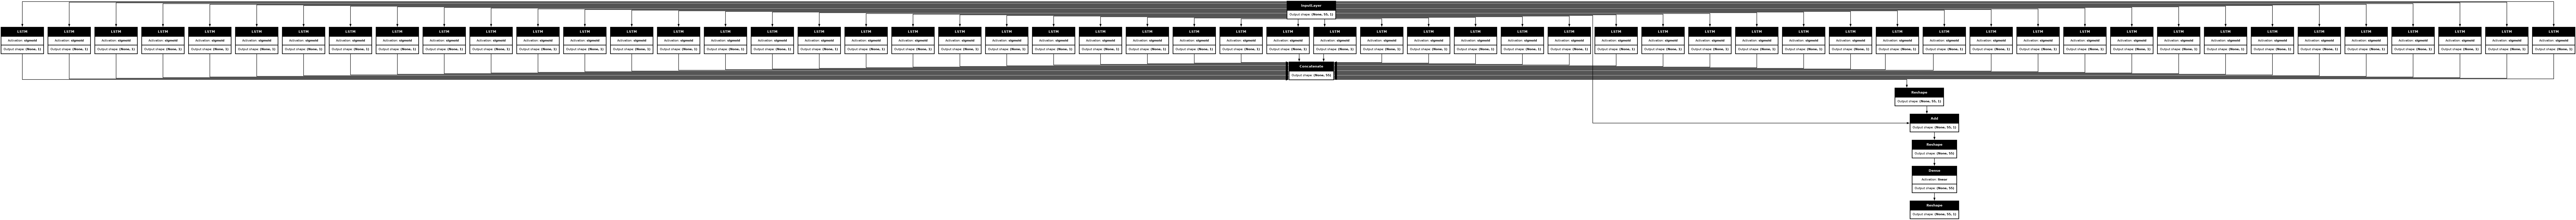

In [13]:
#Defining model architecture

input_layer = keras.layers.Input(shape=(seq_len,1))

lstm_outputs = []
for i in range(seq_len):
    lstm_output = keras.layers.LSTM(1, return_sequences=False, activation='sigmoid')(input_layer)
    lstm_outputs.append(lstm_output)
x = keras.layers.Concatenate()(lstm_outputs)
x = keras.layers.Reshape((seq_len, 1))(x)
x = keras.layers.Add()([input_layer, x])
x = keras.layers.Reshape((seq_len,))(x)
x = keras.layers.Dense(seq_len, activation="linear")(x)
output_layer = keras.layers.Reshape((seq_len, 1))(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=opt, loss="mean_absolute_error")

#Display model
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_activations=True, dpi=96)

In [14]:
#Training
history = model.fit(train_model_input, train_model_output, validation_data=(test_model_input, test_model_output), epochs=epochs, batch_size=batch_size, callbacks=[es, reduce_lr])

Epoch 1/30


I0000 00:00:1712205931.587714     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 153s 840ms/step - loss: 12.5256 - val_loss: 6.2670 - learning_rate: 0.0100
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 406ms/step - loss: 4.7749 - val_loss: 1.8594 - learning_rate: 0.0100
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 406ms/step - loss: 1.7697 - val_loss: 1.2144 - learning_rate: 0.0100
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - loss: 1.1587 - val_loss: 0.9898 - learning_rate: 0.0100
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - loss: 0.8955 - val_loss: 0.7709 - learning_rate: 0.0100
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - loss: 0.7786 - val_loss: 0.7412 - learning_rate: 0.0100
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - loss: 0.7273 - val_loss: 0.6942 - learning_rate: 0.0100
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 406ms/step - loss: 0.7059 - val_loss: 0.7110 - learning_rate: 0.0100
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - loss: 0.6954 - val_loss: 0.6659 - learning_rate: 0.0100
Epoch 10/3

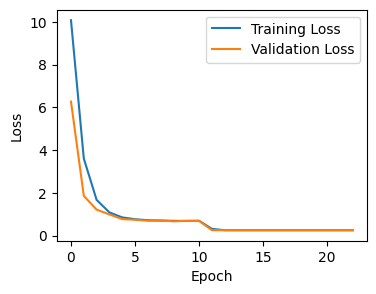

In [15]:
#Train vs Validation loss curve
plot_loss(history)

In [16]:
#Saving the model
model.save('lstm-subtractive-generator.keras')

## ⚙️ Postprocessing utility functions

In [18]:
def custom_transformation(x):
    '''
    Returns next predicted float value using the predicted sequence
    Reference: https://codingvision.net/c-predict-random-number-generator-net
    '''
    offset = 21
    index1, index2 = 0, offset
    
    if index1 >= 55:
        index1 = 0
    if index2 >= 55:
        index2 = 0

    diff = x[:, index1] - x[:, index2]
    output_value = tf.where(diff == 2147483647, -1 / 2147483647.0, diff)
    output_value = tf.where(output_value < 0, output_value + 1, output_value)
    return tf.expand_dims(output_value, axis=-1)

## 🔮 Inference

In [53]:
#Load the model
model = tf.keras.models.load_model("lstm-subtractive-generator.keras")

#### Visualizing initial 100 samples predictions

In [54]:
n_pred = 100
y_pred_float_sequence = model.predict(test_model_input[:n_pred]).reshape(-1,seq_len)/37
y_pred_float = custom_transformation(y_pred_float_sequence)*37
y_pred_int = tf.cast(y_pred_float, dtype=tf.int32)

y_pred = tf.squeeze(y_pred_int).numpy()
y_true = tf.squeeze(test_future_int[:n_pred]).numpy()

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step


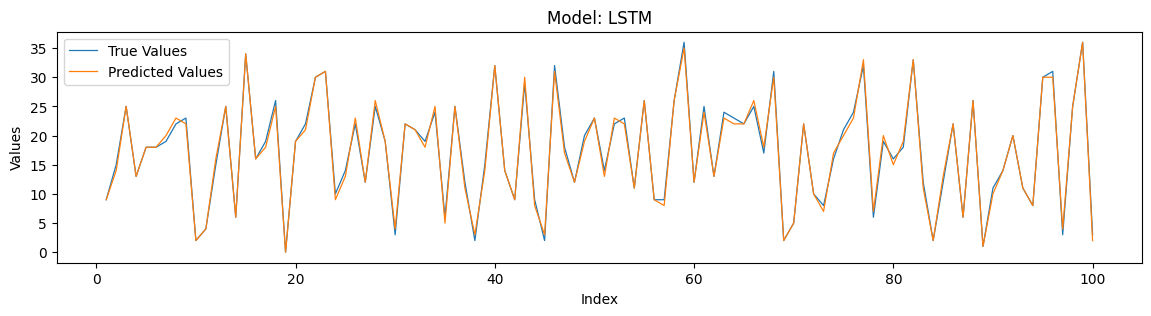

In [55]:
plot_predictions(y_true, y_pred)

#### Visualizing random samples predictions

In [56]:
def random_predictions(test_model_input, test_future_int, n_pred=100):
    '''Returns true and predicted values of randomly selected n_pred samples'''
    random_indices = np.random.choice(len(test_model_input), size=n_pred, replace=False)
    test_model_input1 = test_model_input[random_indices]
    y_pred_float_sequence = model.predict(test_model_input1[:n_pred]).reshape(-1,seq_len)/37
    y_pred_float = custom_transformation(y_pred_float_sequence)*37
    y_pred_int = tf.cast(y_pred_float, dtype=tf.int32)
    y_pred = tf.squeeze(y_pred_int).numpy()
    y_true = tf.squeeze(test_future_int[random_indices]).numpy()
    return y_true, y_pred

y_true1, y_pred1 = random_predictions(test_model_input, test_future_int, 100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


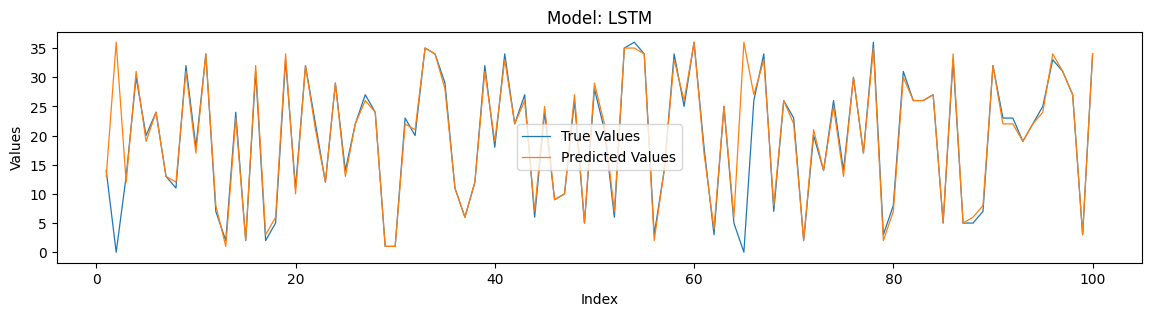

In [57]:
plot_predictions(y_true1, y_pred1)

#### Code for manual prediction

In [58]:
def get_predictions(x_test, model, n_pred = 1):
    """
    x_test: (batch_size, seq_len, 1)
    """
    y_pred_float_sequence = model.predict(x_test[:n_pred], verbose=0).reshape(-1,seq_len)/37
    y_pred_float = custom_transformation(y_pred_float_sequence)*37
    print("Predicted float:",float(y_pred_float[0][0]))
    y_pred_int = tf.cast(y_pred_float, dtype=tf.int32)
    y_pred = tf.squeeze(y_pred_int).numpy()
    print("Predicted integer:", y_pred)

In [59]:
manual_sequence=[6, 22, 18, 28, 5, 0, 27, 36, 17, 17, 23, 36, 28, 15, 5, 6, 20, 26, 2, 9, 17, 8, 5, 4, 26, 6, 20, 4, 30, 32, 24, 20, 0, 28, 34, 17, 29, 25, 9, 34, 14, 36, 16, 30, 17, 19, 7, 13, 32, 29, 21, 12, 16, 1, 9]
print("Input length:",len(manual_sequence))

manual_sequence = np.array(manual_sequence).reshape(1,55,1)
manual_pred = get_predictions(manual_sequence,model, n_pred=1)
manual_pred

Input length: 55
Predicted float: 34.934776306152344
Predicted integer: 34


Predicted integer is correct and close to original (34, 34.22415687)